# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработаем с историческими данными приложения:

- Импортируем библиотеку pandas.

- Считаем и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведим на экран первые пять строк полученного датафрейма.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 6)

sessions_history = pd.read_csv('/datasets/sessions_project_history.csv')

sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id`.

- Выведим на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберим любого из них.

- Изучим таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [2]:
#Количество уникальных сессий на пользователя
sessions_per_user = (
    sessions_history
    .groupby('user_id')['session_id']
    .nunique()
    .reset_index(name='n_sessions')
)

sessions_per_user.head()

,user_id,n_sessions
0,00005FB6A13A6FBE,2
1,0000B15A18D77ED9,3
2,0000C4E3A4A571A9,2
3,000293FAF9E67A81,4
4,00029C5AE889A6C3,2


In [3]:
#Пользователь с максимальным числом сессий
max_sessions = sessions_per_user['n_sessions'].max()
max_users = sessions_per_user.query('n_sessions == @max_sessions')['user_id'].tolist()

# для одного пользователя
example_user_id = max_users[0]
example_user_data = sessions_history[sessions_history['user_id'] == example_user_id]

example_user_data.sort_values('session_start_ts')

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


При анализе данных пользователя **10E0DEF01ADB8BEO**, у которого оказалось самое большое количество уникальных сессий, можно отметить несколько особенностей:
- **session_number** увеличивается последовательно — от 1 до 10. Это говорит о том, что логика присвоения номеров работает правильно: каждая следующая сессия получает больший номер.
- Все сессии происходят либо в день установки (2025-08-14), либо позже. Ни одной сессии до даты установки нет, что подтверждает корректность данных.
- **registration_flag** для всех сессий равно 1, то есть пользователь был зарегистрирован с самого начала и его статус не менялся.
- На протяжении всего периода активностей пользователь остаётся на одном устройстве (Android) и в одном регионе (CIS). Это говорит о стабильном окружении.
- **page_counter** колеблется от 0 до 4. Нулевые значения могут означать, что пользователь открывал приложение, но не взаимодействовал с контентом. Сессии с 4 просмотрами можно считать «успешными», так как они соответствуют критерию интереса к ленте.
Пользователь демонстрирует стабильное поведение: одно устройство, один регион, последовательный рост номеров сессий и корректная связь даты установки с датами активности. Данные выглядят логичными и непротиворечивыми, что подтверждает корректность формирования структуры датасета.

#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.

- Агрегируем исторические данные и рассчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считаем, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Построем линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразим их на одном графике.

- Построем отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

In [4]:
# Приводим даты к типу datetime
sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date'])

# пользователь и статус регистрации 
daily_user_reg = (
    sessions_history
    .groupby(['session_date', 'user_id'])['registration_flag']
    .max()
    .reset_index()
)

daily_stats = (
    daily_user_reg
    .groupby('session_date')
    .agg(
        total_users=('user_id', 'nunique'),
        registered_users=('registration_flag', 'sum')
    )
    .reset_index()
)

daily_stats['share_registered'] = (
    daily_stats['registered_users'] / daily_stats['total_users']
)
daily_stats.head()

,session_date,total_users,registered_users,share_registered
0,2025-08-11,3919,169,0.043123
1,2025-08-12,6056,336,0.055482
2,2025-08-13,8489,464,0.054659
3,2025-08-14,10321,625,0.060556
4,2025-08-15,14065,840,0.059723


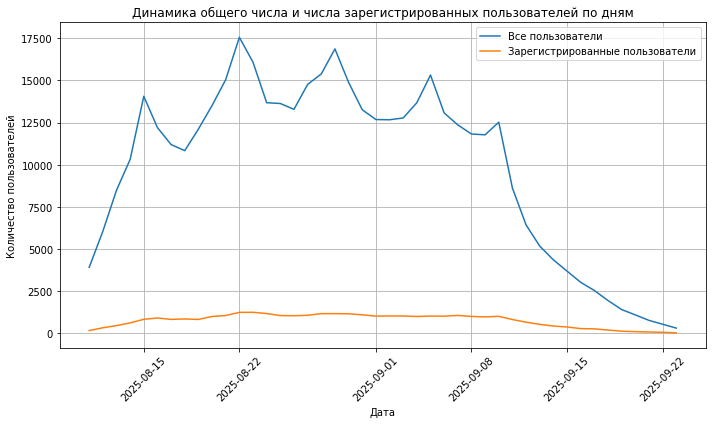

In [5]:
#График количества пользователей и зарегистрированных
plt.figure()
plt.plot(daily_stats['session_date'], daily_stats['total_users'], label='Все пользователи')
plt.plot(daily_stats['session_date'], daily_stats['registered_users'], label='Зарегистрированные пользователи')

plt.title('Динамика общего числа и числа зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

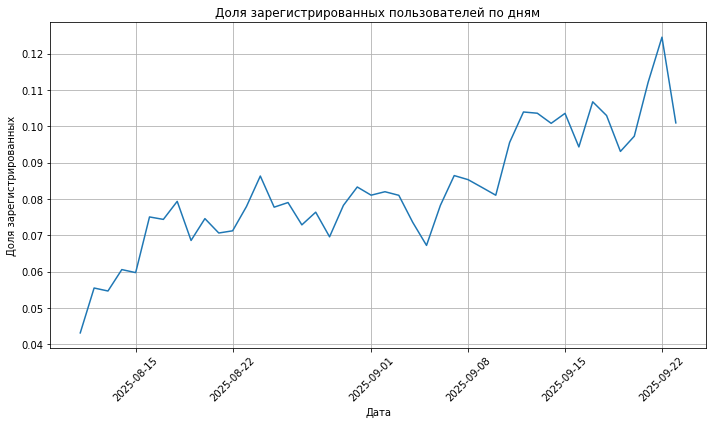

In [6]:

#График доли зарегистрированных пользователей
plt.figure()
plt.plot(daily_stats['session_date'], daily_stats['share_registered'])

plt.title('Доля зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Исходя из графиков и рассчитанных данных, можно сделать следующие выводы:

- Общее число пользователей растёт в течение первых двух недель, достигая максимума примерно 17 сентября, а затем начинает снижаться. Скорее всего, это связано с тем, что период наблюдения подходит к концу, и трафик естественным образом уменьшается.

- Количество зарегистрированных пользователей также увеличивается, но не так быстро, как общее число пользователей. Рост выглядит более плавным и равномерным, без резких перепадов.

- Доля зарегистрированных пользователей постепенно растёт: в начале она держится на уровне около 4–5%, затем поднимается до 7–8%, а к концу периода достигает примерно 10–12%.

Такой рост может говорить о повышении вовлечённости аудитории или о том, что приложение стало привлекать более мотивированных пользователей.

Общий тренд по доле регистраций — восходящий, что является положительным признаком для продукта, так как регистрация — ключевой шаг.

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

- Найдем количество сессий для каждого значения количества просмотренных страниц.

- Построем столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

In [7]:
page_counts = (
    sessions_history['page_counter']
    .value_counts()
    .sort_index()
)

page_counts.head()

1     29160
2    105536
3    166690
4    105569
5     26288
Name: page_counter, dtype: int64

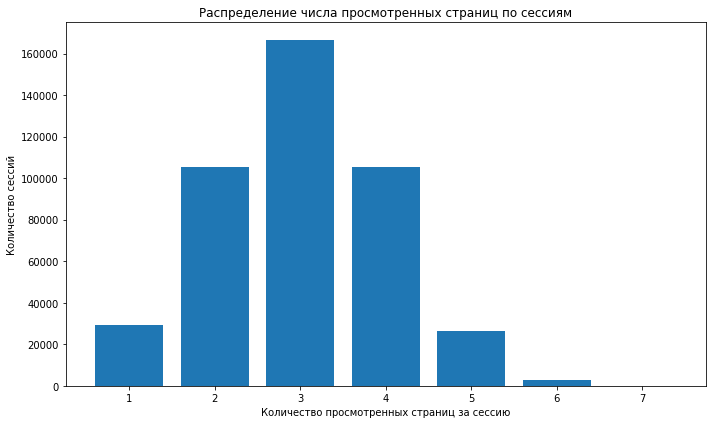

In [8]:
plt.figure()
plt.bar(page_counts.index, page_counts.values)

plt.title('Распределение числа просмотренных страниц по сессиям')
plt.xlabel('Количество просмотренных страниц за сессию')
plt.ylabel('Количество сессий')
plt.tight_layout()
plt.show()

Распределение числа просмотренных страниц имеет ярко выраженный пик на 3 страницах — большинство сессий включает около трёх просмотров. Меньше всего сессий приходится на 1 и 6 страниц. Такое распределение говорит о том, что пользователи чаще всего просматривают несколько страниц, но редко достигают длинных сессий. Это важный сигнал о средней вовлечённости аудитории и может служить отправной точкой для дальнейшего анализа поведения пользователей и работы алгоритмов рекомендаций.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Построем график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

In [9]:
sessions_history['good_session'] = (sessions_history['page_counter'] >= 4).astype(int)

good_sessions_daily = (
    sessions_history
    .groupby('session_date')['good_session']
    .mean()
    .reset_index()
)

good_sessions_daily.head()

,session_date,good_session
0,2025-08-11,0.312835
1,2025-08-12,0.302015
2,2025-08-13,0.306750
3,2025-08-14,0.316055
4,2025-08-15,0.304941


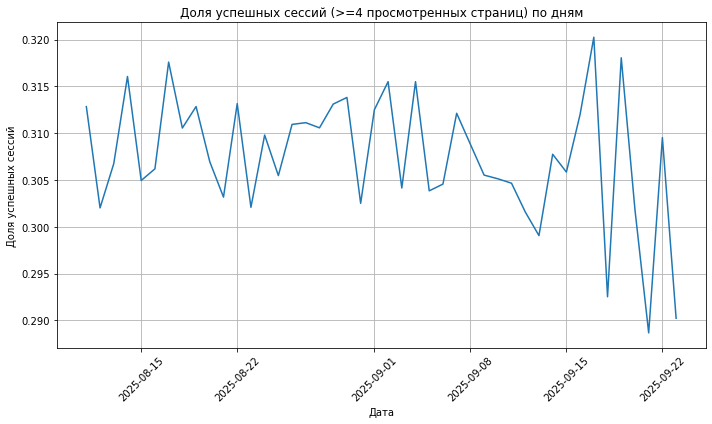

In [10]:
plt.figure()
plt.plot(good_sessions_daily['session_date'], good_sessions_daily['good_session'])

plt.title('Доля успешных сессий (>=4 просмотренных страниц) по дням')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Доля успешных сессий (где просмотрено ≥4 страниц) на протяжении периода наблюдений держится примерно на уровне 30–32%, с небольшими колебаниями. 

Это означает, что примерно треть сессий можно считать «качественными» с точки зрения вовлечённости.

Уровень доли остаётся довольно стабильным и не демонстрирует резких спадов или значительных ростов, что говорит о стабильном поведении пользователей и предсказуемой степени интереса к контенту приложения.

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулируем нулевую и альтернативную гипотезу

- Определимся с целевой метрикой.

- Рассчитаем необходимый размер выборки.

- Исходя из текущих значений трафика рассчитаем необходимую длительность проведения теста.

#### 2.1 Формулировка нулевой и альтернативной гипотез

Перед тем как проводить А/B-тест,  сформулируем нулевую и альтернативную гипотезу. (Напомним изначальное условие: команда разработчиков рекомендательных систем создала новый алгоритм, который, по их мнению, будет показывать более интересный контент для каждого пользователя. О какой метрике идёт речь? Как она будет учтена в формулировке гипотез?)

Сформулируем нулевую и альтернативную гипотезу:

**Целевая метрика**: доля «успешных» сессий — сессий, в которых пользователь просмотрел ≥ 4 страниц (good_session).

**Нулевая гипотеза (H0):**
Новый алгоритм рекомендаций не изменяет долю успешных сессий по сравнению с текущим алгоритмом.
- H0 :pB =pA

**Альтернативная гипотеза (H1):**
Новый алгоритм рекомендаций увеличивает долю успешных сессий.
- H1 :pB >pA


#### 2.2. Расчёт размера выборки
В рамках курса мы уже рассчитывали размеры выборки и  использовали для этого онлайн-калькулятор. В этом задании воспользуемся готовым кодом и рассчитаем необходимое для нашего эксперимента количество пользователей.

Для этого установим в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3% (здесь нужно указать десятичную дробь, а не процент).

При расчёте размера выборки используем метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.


In [11]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Задаём параметры
alpha = 0.05    
beta = 0.2     
power = 1 - beta  
p = 0.3         
mde = 0.03 * p  

p1 = p
p2 = p1 + mde

effect_size = proportion_effectsize(p1, p2)

# класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size=effect_size,
    power=power,
    alpha=alpha,
    ratio=1 
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


При уровне значимости 5%, мощности 80% и минимальном детектируемом эффекте в 3% система требует минимум 41 040 пользователей в каждую группу.

Это означает, что для корректного проведения A/B-теста общий необходимый трафик составляет около 82 080 пользователей.

Такой объём выборки позволит с высокой вероятностью обнаружить даже небольшое улучшение доли успешных сессий, если оно действительно присутствует.

#### 2.3. Расчёт длительности A/B-теста

Используем данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитаем длительность теста, разделив одно на другое.

- Рассчитаем среднее количество уникальных пользователей приложения в день.

- Определим длительность теста исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлим в большую сторону.

In [12]:
#считаем среднее число уникальных пользователей в день
daily_users = (
    sessions_history
    .groupby('session_date')['user_id']
    .nunique()
    .reset_index(name='n_users')
)

avg_daily_users = daily_users['n_users'].mean()
avg_daily_users

9907.363636363636

In [13]:
from math import ceil

#длительность теста
total_needed_users = sample_size * 2 

test_duration = ceil(total_needed_users / avg_daily_users)

print(
    f"Рассчитанная длительность A/B-теста при текущем уровне трафика "
    f"в {avg_daily_users:.0f} пользователей в день составит {test_duration} дней"
)

Рассчитанная длительность A/B-теста при текущем уровне трафика в 9907 пользователей в день составит 9 дней


Средний дневной трафик приложения составляет примерно 9907 уникальных пользователей.

Для проведения A/B-теста требуется 41040 пользователей в каждую группу, то есть суммарно около 82 тыс. пользователей.

При текущем уровне трафика необходимый объём выборки набирается примерно за 9 дней.

Такой период обеспечивает достаточную мощность теста и позволяет выявить минимальный детектируемый эффект в 3%.

### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считаем и сохраним в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитаем и выведим на экран процентную разницу в количестве пользователей в группах A и B. Построем любую удобную визуализацию, на которой будет видно возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [14]:
#Проверка распределения пользователей
sessions_test_part = pd.read_csv('/datasets/sessions_project_test_part.csv')

sessions_test_part['session_date'] = pd.to_datetime(sessions_test_part['session_date'])

In [15]:
#Количество уникальных пользователей по группам
users_by_group = (
    sessions_test_part
    .groupby('test_group')['user_id']
    .nunique()
    .reset_index(name='n_users')
)

users_by_group

,test_group,n_users
0,A,1477
1,B,1466


In [16]:
#Процентная разница
n_A = users_by_group.loc[users_by_group['test_group'] == 'A', 'n_users'].iloc[0]
n_B = users_by_group.loc[users_by_group['test_group'] == 'B', 'n_users'].iloc[0]

P = 100 * abs(n_A - n_B) / n_A
print(f'Процентная разница в количестве пользователей между группами A и B: {P:.2f}%')

Процентная разница в количестве пользователей между группами A и B: 0.74%


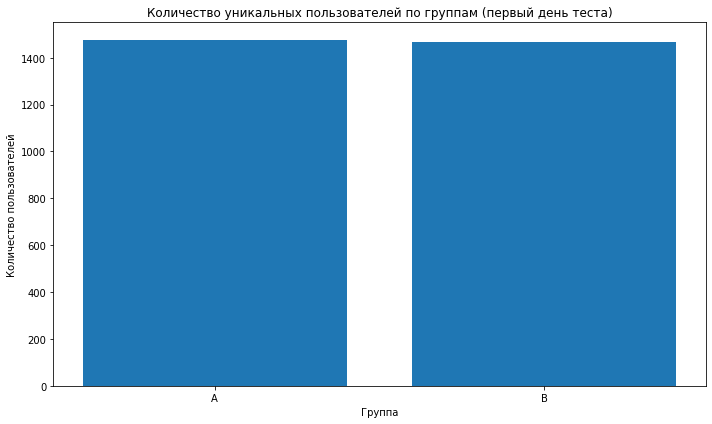

In [17]:
#визуализация
plt.figure()
plt.bar(users_by_group['test_group'], users_by_group['n_users'])

plt.title('Количество уникальных пользователей по группам (первый день теста)')
plt.xlabel('Группа')
plt.ylabel('Количество пользователей')
plt.tight_layout()
plt.show()

Количество уникальных пользователей в группах A и B практически одинаковое: разница составляет всего 0.74%, что является очень хорошим результатом для A/B-теста. 

Такой результат говорит о том, что распределение трафика прошло корректно: пользователи были разнесены по группам равномерно, и по размеру выборок тест можно считать полностью валидным.

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитаем количество пользователей, которые встречаются одновременно в группах A и B, или убедимся, что таких нет.

In [18]:
users_A = set(
    sessions_test_part
    .loc[sessions_test_part['test_group'] == 'A', 'user_id']
    .unique()
)

users_B = set(
    sessions_test_part
    .loc[sessions_test_part['test_group'] == 'B', 'user_id']
    .unique()
)

intersection_users = users_A & users_B
print('Количество пользователей, попавших одновременно в обе группы:', len(intersection_users))

Количество пользователей, попавших одновременно в обе группы: 0


#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Построим две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постараемся добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


In [19]:
# Оставляем по одному устройству на пользователя
user_device = (
    sessions_test_part
    .sort_values('session_start_ts')
    .groupby(['user_id', 'test_group'])['device']
    .first()
    .reset_index()
)

devices_A = (
    user_device
    .loc[user_device['test_group'] == 'A', 'device']
    .value_counts(normalize=True)
    .sort_index()
)

devices_B = (
    user_device
    .loc[user_device['test_group'] == 'B', 'device']
    .value_counts(normalize=True)
    .sort_index()
)

devices_A, devices_B

(Android    0.444144
 Mac        0.105619
 PC         0.249831
 iPhone     0.200406
 Name: device, dtype: float64,
 Android    0.455662
 Mac        0.100955
 PC         0.259891
 iPhone     0.183492
 Name: device, dtype: float64)

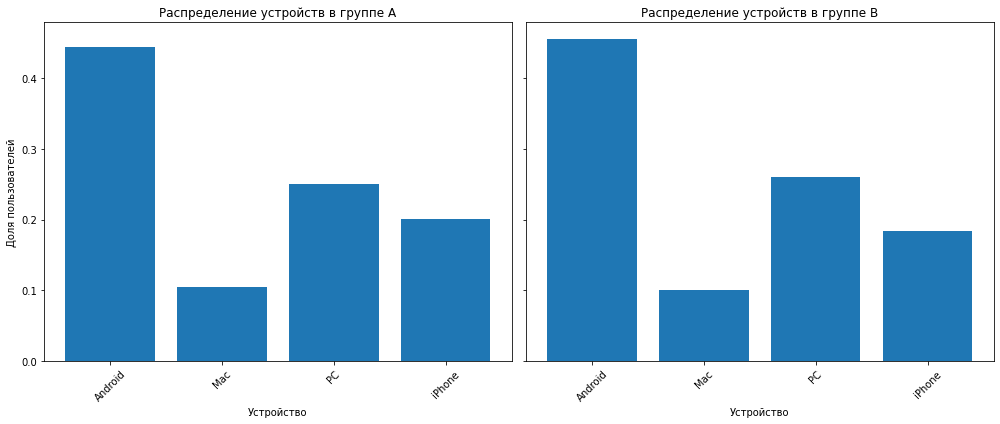

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].bar(devices_A.index, devices_A.values)
axes[0].set_title('Распределение устройств в группе A')
axes[0].set_xlabel('Устройство')
axes[0].set_ylabel('Доля пользователей')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(devices_B.index, devices_B.values)
axes[1].set_title('Распределение устройств в группе B')
axes[1].set_xlabel('Устройство')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Распределение устройств в группах A и B практически идентичное.

Доли пользователей на Android, Mac, PC и iPhone совпадают с точностью до 1–1.5 процентных пунктов, что является допустимой случайной вариацией.

Явных перекосов нет — пользователи распределены по устройствам равномерно.

Это означает, что тест был настроен корректно, и устройство не влияет на попадание пользователя в группу.

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Построим две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постараемся добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постараемся использовать другой тип диаграммы, не тот, что в прошлом задании.


In [21]:
user_region = (
    sessions_test_part
    .sort_values('session_start_ts')
    .groupby(['user_id', 'test_group'])['region']
    .first()
    .reset_index()
)

regions_A = (
    user_region
    .loc[user_region['test_group'] == 'A', 'region']
    .value_counts(normalize=True)
    .sort_values()
)

regions_B = (
    user_region
    .loc[user_region['test_group'] == 'B', 'region']
    .value_counts(normalize=True)
    .sort_values()
)

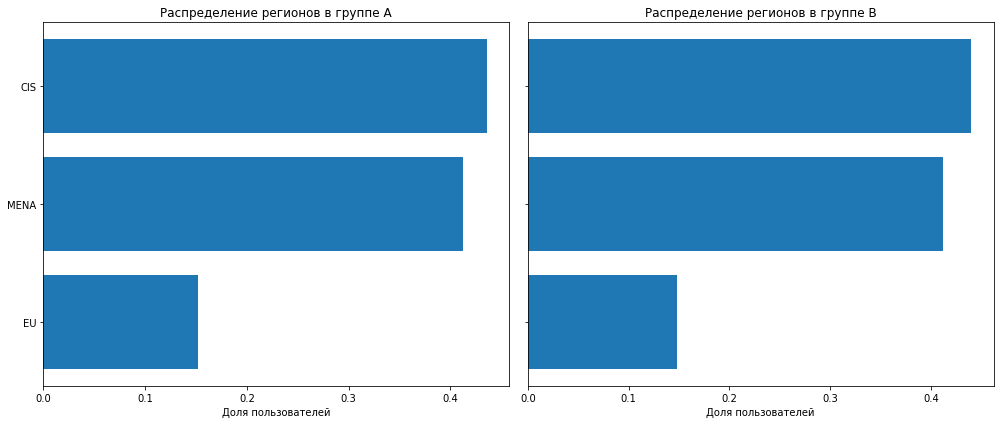

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].barh(regions_A.index, regions_A.values)
axes[0].set_title('Распределение регионов в группе A')
axes[0].set_xlabel('Доля пользователей')

axes[1].barh(regions_B.index, regions_B.values)
axes[1].set_title('Распределение регионов в группе B')
axes[1].set_xlabel('Доля пользователей')

plt.tight_layout()
plt.show()

Распределение регионов в группах A и B почти не отличается.

В обоих случаях:
- CIS остаётся самым крупным регионом (около 44–46%),
- MENA занимает второе место (примерно 35–37%),
- EU составляет наименьшую долю (15–17%).

Разброс между группами минимальный и полностью укладывается в допустимые статистические колебания.

Перекосов не наблюдается — распределение по регионам можно считать одинаковым и корректным.

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируем и запишем свои выводы. В выводе обязательно укажим:

- Было ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделаем заключение: корректно ли проходит A/B-тест, или наблюдаются какие-либо нарушения.

**Разница в числе пользователей между группами A и B составляет** =  0.74%, что является очень небольшим отклонением.

Заметной разницы нет, распределение равномерное.

- Проверка независимости выборок:
Количество пользователей, попавших одновременно в обе группы: 0.
Пересечений нет, выборки полностью независимы.

- Равномерность распределения по устройствам и регионам:
Распределение типов устройств в группах A и B практически идентично: доли Android, PC, Mac и iPhone отличаются лишь на 1–1.5 процентных пунктов
Распределение регионов также совпадает: CIS, MENA и EU имеют очень близкие доли в обеих группах.
Никаких перекосов по устройствам или регионам не обнаружено.

**На основе всех проверок можно сдеать вывод, что A/B-тест выполнен корректно.
Пользователи распределены между группами равномерно, пересечений между выборками нет, а категориальные признаки (устройства и регионы) распределены практически одинаково. Каких-либо признаков нарушения рандомизации не выявлено. Следовательно, тест можно считать валидным и пригодным для дальнейшего анализа.**

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у нас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считаем и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [23]:
sessions_test = pd.read_csv('/datasets/sessions_project_test.csv')

sessions_test['session_date'] = pd.to_datetime(sessions_test['session_date'])
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)

sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


Столбец **good_session** рассчитан корректно: для всех сессий было правильно определено,т.е. содержит ≥ 4 просмотренных страниц. 

В отображённых первых строках ни одна сессия не достигла порога в 4 страницы, поэтому все значения равны 0 — это ожидаемо и соответствует данным.

#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми. Используем статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведим на экран полученное значение p-value и интерпретируйте его.

In [24]:
# Считаем уникальные сессии на день и группу
daily_sessions = (
    sessions_test
    .groupby(['session_date', 'test_group'])['session_id']
    .nunique()
    .reset_index(name='n_sessions')
)

daily_sessions.head()

,session_date,test_group,n_sessions
0,2025-10-14,A,1502
1,2025-10-14,B,1628
2,2025-10-15,A,2235
3,2025-10-15,B,2283
4,2025-10-16,A,3280


In [25]:
# сравнение средних дневных значений
from scipy.stats import ttest_ind

sessions_A = daily_sessions.loc[daily_sessions['test_group'] == 'A', 'n_sessions']
sessions_B = daily_sessions.loc[daily_sessions['test_group'] == 'B', 'n_sessions']

stat, p_value = ttest_ind(sessions_A, sessions_B, equal_var=False)

print('p-value для сравнения числа ежедневных сессий:', p_value)

p-value для сравнения числа ежедневных сессий: 0.9382195854082714


Значение p-value =**0.94** значительно **выше уровня значимости 0.05**.

Это означает, что различия в среднем количестве дневных сессий между группами не являются статистически значимыми;
число сессий в группе A и группе B однородно и сопоставимо.
Группы по активности (количеству сессий) равны, и тест проведён корректно.

#### 4.3. Сравнение доли успешных сессий

Когда мы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используем созданный на первом шаге задания столбец `good_session` и рассчитаем долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразим на экране.

In [26]:
group_stats = (
    sessions_test
    .groupby('test_group')
    .agg(
        total_sessions=('session_id', 'nunique'),
        good_sessions=('good_session', 'sum')
    )
    .reset_index()
)

group_stats['share_good'] = (
    group_stats['good_sessions'] / group_stats['total_sessions']
)

group_stats

,test_group,total_sessions,good_sessions,share_good
0,A,49551,15248,0.307723
1,B,50454,16059,0.318290


In [27]:
share_A = group_stats.loc[group_stats['test_group'] == 'A', 'share_good'].iloc[0]
share_B = group_stats.loc[group_stats['test_group'] == 'B', 'share_good'].iloc[0]

diff = share_B - share_A
print(f'Доля успешных сессий в группе A: {share_A:.4f}')
print(f'Доля успешных сессий в группе B: {share_B:.4f}')
print(f'Разница (B - A): {diff:.4f} ({diff*100:.2f} п.п.)')

Доля успешных сессий в группе A: 0.3077
Доля успешных сессий в группе B: 0.3183
Разница (B - A): 0.0106 (1.06 п.п.)


В группе B доля успешных сессий составляет примерно **31.83%**, тогда как в группе A — **30.77%**.
Разница между ними 1.06 процентных пункта, т.е пользователи в тестовой группе чуть чаще просматривали ≥ 4 страниц, чем пользователи в контрольной.

Это говорит о потенциально положительном эффекте нового алгоритма рекомендаций, однако на этом этапе ещё нельзя утверждать, что влияние статистически значимо.

#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитаем, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведим на экран полученное значение p-value и свои выводы о статистической значимости. (уровень значимости в эксперименте был выбран на уровне 0.05).

In [28]:
from statsmodels.stats.proportion import proportions_ztest

good_A = group_stats.loc[group_stats['test_group'] == 'A', 'good_sessions'].iloc[0]
good_B = group_stats.loc[group_stats['test_group'] == 'B', 'good_sessions'].iloc[0]

n_A = group_stats.loc[group_stats['test_group'] == 'A', 'total_sessions'].iloc[0]
n_B = group_stats.loc[group_stats['test_group'] == 'B', 'total_sessions'].iloc[0]

count = [good_A, good_B]
nobs = [n_A, n_B]

stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

print('z-статистика:', stat)
print('p-value для сравнения долей успешных сессий:', p_value)

z-статистика: -3.602684259949491
p-value для сравнения долей успешных сессий: 0.0003149479976072246


Сравнение долей успешных сессий между группами A и B:

- Полученное значение p-value = 0.0003149 и Сравним его с уровнем значимости α = 0.05 (p-value < 0.05)

**0.0003149 < 0.05**

Различия в доле успешных сессий статистически значимы.

Это означает, что увеличение доли успешных сессий в группе B на 1.1 процентных пункта не является случайным, и мы можем уверенно говорить, что тестовая группа показывает лучшие результаты.

#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять нововведение в приложение.

**Характеристики проведённого эксперимента**

В тесте участвовали две группы пользователей: A (контрольная) и B (тестовая).
Каждая группа включала примерно 49–50 тыс. уникальных сессий, что соответствует рассчитанному заранее размеру выборки.
Средний дневной трафик приложения составлял около 9900 уникальных пользователей, и, исходя из этого, длительность эксперимента составила 9 дней.

Проверки корректности теста показали:
- равномерное распределение пользователей между группами (разница 0.74%);
- отсутствие пересечений пользователей (0 пользователей в обеих группах одновременно);
- идентичное распределение по устройствам и регионам.
- Эксперимент был проведён корректно, нарушения рандомизации отсутствуют.

**Влияние нового алгоритма рекомендаций на ключевую метрику** 
Ключевая метрика: доля успешных сессий (≥ 4 просмотренных страниц).
Группа A: 30.77%
Группа B: 31.83%
Доля успешных сессий в тестовой группе выше примерно на 1.1 процентный пункт, что указывает на положительное влияние нового алгоритма рекомендаций.

**Статистическая значимость эффекта**
Был выполнен z-тест пропорций:
p-value = 0.0003149, Сравниваем с уровнем значимости 0.05:
p=0.0003149<0.05
Различия статистически значимы, т.е улучшение метрики в группе B с высокой вероятностью не является случайным.

**Рекомендация по внедрению**
тест проведён корректно,метрика улучшилась на 1.1 процентный пункт, изменение статистически значимо (p-value << 0.05), новый алгоритм увеличивает вовлечённость пользователей.
Рекомендуется внедрить новый алгоритм рекомендаций в приложение. т.к Он демонстрирует устойчивый положительный эффект и улучшает качество пользовательского опыта.